
(ﾉ ﾟｰﾟ)ﾉ
Tutorial (probably): https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

(ﾉ ﾟｰﾟ)ﾉ
Models:
https://pytorch.org/vision/stable/models.html#general-information-on-pre-trained-weights

(ﾉ ﾟｰﾟ)ﾉ
Datasets:
https://pytorch.org/vision/stable/datasets.html

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

#don't forget: net.to(device)

## Hyperparams

In [2]:
batch_size=64
n_threads = 4

# hardware dependent:
data_folder = '.data'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task1 - Dataset
Loading set + showing example images and size



### Load and visualize data

In [3]:
# new 
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

feature_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Create Omniglot dataset
trainset = torchvision.datasets.Omniglot(root=data_folder, background=True,
                                        download=True, transform=feature_transforms)

testset = torchvision.datasets.Omniglot(root=data_folder, background=False,
                                        download=True, transform=feature_transforms)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

trainsize = len(trainset)
testsize = len(testset)

#class_names = trainset.classes


Files already downloaded and verified
Files already downloaded and verified


In [4]:
next(iter(trainloader))[0].shape

torch.Size([64, 1, 105, 105])

Dataset length:  Dataset Omniglot
    Number of datapoints: 19280
    Root location: .data\omniglot-py
    StandardTransform
Transform: Compose(
               ToTensor()
           )


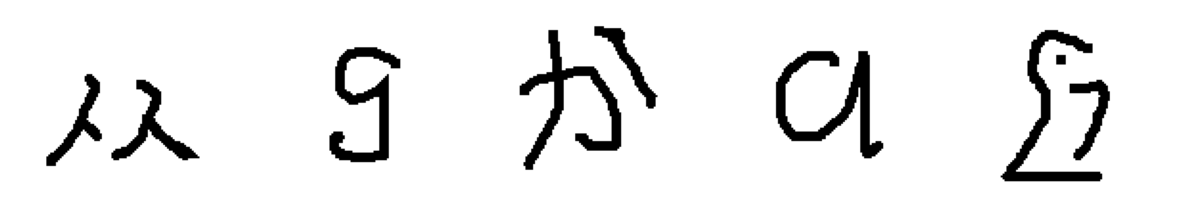

In [5]:
print('Dataset length: ', trainset)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images

random_indices = random.sample(range(len(trainset)), 5)
random_images = [trainset[i][0] for i in random_indices]

# Display random images
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(random_images[i][0], cmap='gray')
    axs[i].axis('off')

plt.show()

### Finetuning
- every layer

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to the number of character classes in the dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
num_characters = len(trainset._characters)
model_ft.fc = nn.Linear(num_ftrs, num_characters)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in trainloader if phase == "train" else testloader:
                    inputs = inputs.squeeze()
                    inputs = torch.stack((inputs, inputs, inputs), dim=1)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()

                used_set = trainset if phase == "train" else testset
                epoch_loss = running_loss / len(used_set)
                epoch_acc = running_corrects.double() / len(used_set)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [8]:
# Training results:
# ResNet: 8:40 on GPU, 95% on train data, 

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 6.9470 Acc: 0.0027
val Loss: 7.0196 Acc: 0.0017

Epoch 1/24
----------
train Loss: 6.5336 Acc: 0.0152
val Loss: 7.0036 Acc: 0.0009

Epoch 2/24
----------
train Loss: 6.1811 Acc: 0.0498
val Loss: 7.0216 Acc: 0.0008

Epoch 3/24
----------
train Loss: 5.8550 Acc: 0.1001
val Loss: 7.0326 Acc: 0.0007

Epoch 4/24
----------
train Loss: 5.5529 Acc: 0.1558
val Loss: 7.0598 Acc: 0.0006

Epoch 5/24
----------
train Loss: 5.2644 Acc: 0.2182
val Loss: 7.0955 Acc: 0.0008

Epoch 6/24
----------
train Loss: 4.9943 Acc: 0.2732
val Loss: 7.1460 Acc: 0.0009

Epoch 7/24
----------
train Loss: 4.8068 Acc: 0.3261
val Loss: 7.1262 Acc: 0.0010

Epoch 8/24
----------
train Loss: 4.7814 Acc: 0.3351
val Loss: 7.1438 Acc: 0.0009

Epoch 9/24
----------
train Loss: 4.7533 Acc: 0.3374
val Loss: 7.1401 Acc: 0.0009

Epoch 10/24
----------
train Loss: 4.7305 Acc: 0.3462
val Loss: 7.1429 Acc: 0.0012

Epoch 11/24
----------
train Loss: 4.7057 Acc: 0.3486
val Loss: 7.1520 Acc: 0.0009

Ep